# Importing Necessary Libraries

In [1]:
import torch
print(torch.__version__)

1.7.1


In [2]:
import os
from pathlib import Path
import random
import sys
import numpy as np
import os, json, cv2, random

from tqdm.notebook import tqdm
import pandas as pd


import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [7]:
print(torch.cuda.is_available())

True


In [10]:
# --- plotly ---
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
import plotly.io as pio
pio.templates.default = "plotly_dark"

In [11]:
# import some common detectron2 utilities
# Methods for prediction for this competition
from math import ceil
from typing import Any, Dict, List

import cv2
import detectron2
import numpy as np
from numpy import ndarray
import pandas as pd
import torch
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.engine import DefaultPredictor
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.structures import BoxMode
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import ColorMode, Visualizer
from detectron2.engine import DefaultTrainer
from detectron2.engine.hooks import HookBase
from detectron2.evaluation import inference_context
from detectron2.utils.logger import log_every_n_seconds
from detectron2.data import DatasetMapper, build_detection_test_loader
import detectron2.utils.comm as comm
import torch
import time
import datetime
import logging
from tqdm import tqdm
setup_logger()

In [13]:
# --- setup ---
pd.set_option('max_columns', 50)

# Main code starts from here

In [16]:
import os
os.getcwd()

'/home/ubuntu/Pytorch_chest_Xray'

In [17]:
#reading the train_meta file
train_meta1 = pd.read_csv( "./Images/train_meta.csv")

In [18]:
train_meta1.head(4)

,image_id,dim0,dim1
0,4d390e07733ba06e5ff07412f09c0a92,3000,3000
1,289f69f6462af4933308c275d07060f0,3072,3072
2,68335ee73e67706aa59b8b55b54b11a4,2836,2336
3,7ecd6f67f649f26c05805c8359f9e528,2952,2744


In [19]:
train_meta1.shape

(15000, 3)

In [20]:
train_meta1.head(2)

,image_id,dim0,dim1
0,4d390e07733ba06e5ff07412f09c0a92,3000,3000
1,289f69f6462af4933308c275d07060f0,3072,3072


In [21]:
train_meta = train_meta1.iloc[0:12000,:]

In [22]:
#splitting the test data
test_meta = train_meta1.iloc[12000:15000,:]

In [24]:
#metadata with one row for each object
train = pd.read_csv("./Images/train.csv")

In [25]:
train.shape

(67914, 8)

In [26]:
train.head(10)

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN
5,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,11,R9,627.0,357.0,947.0,433.0
6,0c7a38f293d5f5e4846aa4ca6db4daf1,ILD,5,R17,1347.0,245.0,2188.0,2169.0
7,47ed17dcb2cbeec15182ed335a8b5a9e,Nodule/Mass,8,R9,557.0,2352.0,675.0,2484.0
8,d3637a1935a905b3c326af31389cb846,Aortic enlargement,0,R10,1329.0,743.0,1521.0,958.0
9,afb6230703512afc370f236e8fe98806,Pulmonary fibrosis,13,R9,1857.0,1607.0,2126.0,2036.0


In [27]:
train_meta.reset_index(drop=True, inplace=True)
test_meta.reset_index(drop=True, inplace=True)

In [28]:
#get shape of the actula image to do scaling
image_id = train_meta.loc[0, "image_id"]
image_path = f"./Images/train/{image_id}.png"# str(imgdir / "train" / f"{image_id}.png")
image = cv2.imread(image_path)
resized_height, resized_width, ch = image.shape
print(f"image shape: {image.shape}")

image shape: (256, 256, 3)


In [29]:
#training data prep
def get_train_dict():
    dataset_dicts_train=[]
    for index, train_meta_row in tqdm(train_meta.iterrows(), total=len(train_meta)):
        record = {}
        image_id, height, width = train_meta_row.values
        filename = f"./Images/train/{image_id}.png"
        record["file_name"] = filename
        record["image_id"] = index
        record["height"] = resized_height
        record["width"] = resized_width
        #print(index)
        #print(train_meta_row)
        objs=[]
        for index2, row in train.query("image_id == @image_id").iterrows():
                    # print(row)
                    # print(row["class_name"])
                    # class_name = row["class_name"]
            class_id = row["class_id"]
            if class_id == 14:
                pass
            else:
                # bbox_original = [int(row["x_min"]), int(row["y_min"]), int(row["x_max"]), int(row["y_max"])]
                h_ratio = resized_height / height
                w_ratio = resized_width / width
                bbox_resized = [
                    int(row["x_min"]) * w_ratio,
                    int(row["y_min"]) * h_ratio,
                    int(row["x_max"]) * w_ratio,
                    int(row["y_max"]) * h_ratio,
                ]
                obj = {
                    "bbox": bbox_resized,
                    "bbox_mode": BoxMode.XYXY_ABS,
                    "category_id": class_id,
                }
                objs.append(obj)
        record["annotations"] = objs
        dataset_dicts_train.append(record)
    return dataset_dicts_train
#with open("train_data_dict.pkl", mode="wb") as f:
 #   pickle.dump(dataset_dicts, f)

In [31]:
#just checking test data image shape again
image_id = test_meta.loc[0, "image_id"]
image_path = f"./Images/train/{image_id}.png"
image = cv2.imread(image_path)
resized_height, resized_width, ch = image.shape
print(f"image shape: {image.shape}")

image shape: (256, 256, 3)


In [32]:
#test data prep
def get_test_dict():
    dataset_dicts_test = []
    for index, test_meta_row in tqdm(test_meta.iterrows(), total=len(test_meta)):
        record = {}

        image_id, height, width = test_meta_row.values
        filename = f"./Images/train/{image_id}.png"
        record["file_name"] = filename
        record["image_id"] = index
        record["height"] = resized_height
        record["width"] = resized_width
        objs=[]
        for index2, row in train.query("image_id == @image_id").iterrows():
                    # print(row)
                    # print(row["class_name"])
                    # class_name = row["class_name"]
            class_id = row["class_id"]
            if class_id == 14:
                pass
                # It is "No finding"
                # This annotator does not find anything, skip.
            else:
                # bbox_original = [int(row["x_min"]), int(row["y_min"]), int(row["x_max"]), int(row["y_max"])]
                h_ratio = resized_height / height
                w_ratio = resized_width / width
                bbox_resized = [
                    int(row["x_min"]) * w_ratio,
                    int(row["y_min"]) * h_ratio,
                    int(row["x_max"]) * w_ratio,
                    int(row["y_max"]) * h_ratio,
                ]
                obj = {
                    "bbox": bbox_resized,
                    "bbox_mode": BoxMode.XYXY_ABS,
                    "category_id": class_id,
                }
                objs.append(obj)
        record["annotations"] = objs
        dataset_dicts_test.append(record)
    return dataset_dicts_test
        # objs = []
        # record["annotations"] = obj
#with open(cache_path, mode="wb") as f:
 #   pickle.dump(dataset_dicts, f)

#print(f"Load from cache train_data_dict")
#with open(train_data_dict.pkl, mode="rb") as f:
#    dataset_dicts = pickle.load(f)
#return dataset_dicts

In [33]:
thing_classes = [
    "Aortic enlargement",
    "Atelectasis",
    "Calcification",
    "Cardiomegaly",
    "Consolidation",
    "ILD",
    "Infiltration",
    "Lung Opacity",
    "Nodule/Mass",
    "Other lesion",
    "Pleural effusion",
    "Pleural thickening",
    "Pneumothorax",
    "Pulmonary fibrosis"
]
category_name_to_id = {class_name: index for index, class_name in enumerate(thing_classes)}

In [34]:
thing_classes

['Aortic enlargement',
 'Atelectasis',
 'Calcification',
 'Cardiomegaly',
 'Consolidation',
 'ILD',
 'Infiltration',
 'Lung Opacity',
 'Nodule/Mass',
 'Other lesion',
 'Pleural effusion',
 'Pleural thickening',
 'Pneumothorax',
 'Pulmonary fibrosis']

In [35]:
category_name_to_id

{'Aortic enlargement': 0,
 'Atelectasis': 1,
 'Calcification': 2,
 'Cardiomegaly': 3,
 'Consolidation': 4,
 'ILD': 5,
 'Infiltration': 6,
 'Lung Opacity': 7,
 'Nodule/Mass': 8,
 'Other lesion': 9,
 'Pleural effusion': 10,
 'Pleural thickening': 11,
 'Pneumothorax': 12,
 'Pulmonary fibrosis': 13}

In [36]:
#registering tain data to DatasetCatalog
DatasetCatalog.register(
    "vinbigdata_train", lambda: get_train_dict()
)
MetadataCatalog.get("vinbigdata_train").set(thing_classes=thing_classes)


namespace(name='vinbigdata_train',
          thing_classes=['Aortic enlargement',
                         'Atelectasis',
                         'Calcification',
                         'Cardiomegaly',
                         'Consolidation',
                         'ILD',
                         'Infiltration',
                         'Lung Opacity',
                         'Nodule/Mass',
                         'Other lesion',
                         'Pleural effusion',
                         'Pleural thickening',
                         'Pneumothorax',
                         'Pulmonary fibrosis'])

In [37]:
#registering test data to DatasetCatalog
DatasetCatalog.register(
    "vinbigdata_test", lambda: get_test_dict()
)
MetadataCatalog.get("vinbigdata_test").set(thing_classes=thing_classes)

namespace(name='vinbigdata_test',
          thing_classes=['Aortic enlargement',
                         'Atelectasis',
                         'Calcification',
                         'Cardiomegaly',
                         'Consolidation',
                         'ILD',
                         'Infiltration',
                         'Lung Opacity',
                         'Nodule/Mass',
                         'Other lesion',
                         'Pleural effusion',
                         'Pleural thickening',
                         'Pneumothorax',
                         'Pulmonary fibrosis'])

In [38]:
metadata_train = MetadataCatalog.get("vinbigdata_train")

100%|██████████| 12000/12000 [00:38<00:00, 313.60it/s]


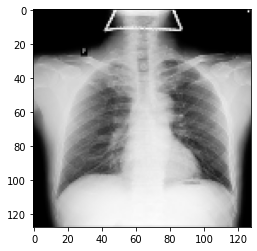

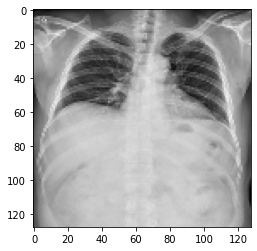

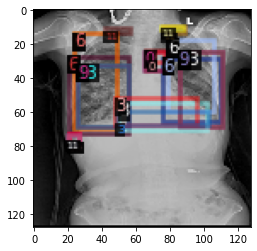

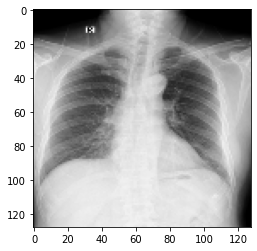

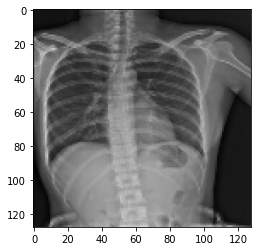

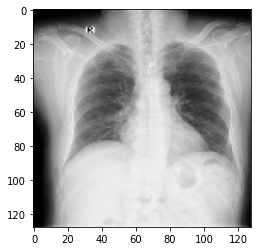

In [39]:
#visualizing train data to check if it was loaded correctly in DatasetCatalog
dataset_dicts = get_train_dict()
for d in random.sample(dataset_dicts, 6):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=metadata_train, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()

In [41]:
#hook to include extra information which doesnt come by default such as validation loss,
class LossEvalHook(HookBase):
    def __init__(self, eval_period, model, data_loader):
        self._model = model
        self._period = eval_period
        self._data_loader = data_loader
    
    def _do_loss_eval(self):
        # Copying inference_on_dataset from evaluator.py
        total = len(self._data_loader)
        num_warmup = min(5, total - 1)
            
        start_time = time.perf_counter()
        total_compute_time = 0
        losses = []
        for idx, inputs in enumerate(self._data_loader):            
            if idx == num_warmup:
                start_time = time.perf_counter()
                total_compute_time = 0
            start_compute_time = time.perf_counter()
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            total_compute_time += time.perf_counter() - start_compute_time
            iters_after_start = idx + 1 - num_warmup * int(idx >= num_warmup)
            seconds_per_img = total_compute_time / iters_after_start
            if idx >= num_warmup * 2 or seconds_per_img > 5:
                total_seconds_per_img = (time.perf_counter() - start_time) / iters_after_start
                eta = datetime.timedelta(seconds=int(total_seconds_per_img * (total - idx - 1)))
                log_every_n_seconds(
                    logging.INFO,
                    "Loss on Validation  done {}/{}. {:.4f} s / img. ETA={}".format(
                        idx + 1, total, seconds_per_img, str(eta)
                    ),
                    n=5,
                )
            loss_batch = self._get_loss(inputs)
            losses.append(loss_batch)
        mean_loss = np.mean(losses)
        self.trainer.storage.put_scalar('validation_loss', mean_loss)
        comm.synchronize()

        return losses
            
    def _get_loss(self, data):
        # How loss is calculated on train_loop 
        metrics_dict = self._model(data)
        metrics_dict = {
            k: v.detach().cpu().item() if isinstance(v, torch.Tensor) else float(v)
            for k, v in metrics_dict.items()
        }
        total_losses_reduced = sum(loss for loss in metrics_dict.values())
        return total_losses_reduced
        
        
    def after_step(self):
        next_iter = self.trainer.iter + 1
        is_final = next_iter == self.trainer.max_iter
        if is_final or (self._period > 0 and next_iter % self._period == 0):
            self._do_loss_eval()
        self.trainer.storage.put_scalars(timetest=12)


In [42]:
#defining my own trainer to invoke the hook and using CoCoEvaluator from Detectron2
class MyTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(dataset_name, cfg, True, output_folder)
                     
    def build_hooks(self):
        hooks = super().build_hooks()
        hooks.insert(-1,LossEvalHook(
            cfg.TEST.EVAL_PERIOD,
            self.model,
            build_detection_test_loader(
                self.cfg,
                self.cfg.DATASETS.TEST[0],
                DatasetMapper(self.cfg,True)
            )
        ))
        return hooks

In [43]:
#tried augmentation
from detectron2.config.config import CfgNode as CN
aug_kwargs = {
        "HorizontalFlip": {"p": 0.5},
        "ShiftScaleRotate": {"scale_limit": 0.15, "rotate_limit": 10, "p": 0.5},
        "RandomBrightnessContrast": {"p": 0.5}
    }

In [44]:
#defining the parameters in Detectron2 and reading the pretrained model from model zoo and getting its weights
cfg = get_cfg()
cfg.MODEL.DEVICE='cuda'
cfg.aug_kwargs = CN(aug_kwargs)
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.0
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("vinbigdata_train",)
cfg.DATASETS.TEST = ("vinbigdata_test",)
#cfg.DATASETS.TEST = ()
cfg.TEST.EVAL_PERIOD = 1000
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/retinanet_R_101_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 1
cfg.SOLVER.lr_scheduler_name = "LRMultiplier"
cfg.SOLVER.BASE_LR = 0.001  # pick a good LR
cfg.SOLVER.MAX_ITER = 10000    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 14  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = MyTrainer(cfg)
#trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

Loading config /home/ubuntu/.local/lib/python3.8/site-packages/detectron2/model_zoo/configs/COCO-Detection/../Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


[05/03 18:46:38 d2.engine.defaults]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2)

100%|██████████| 12000/12000 [00:38<00:00, 313.26it/s]

[05/03 18:47:17 d2.data.build]: Removed 8485 images with no usable annotations. 3515 images left.


[05/03 18:47:17 d2.data.build]: Distribution of instances among all 14 categories:
|   category    | #instances   |   category    | #instances   |   category    | #instances   |
|:-------------:|:-------------|:-------------:|:-------------|:-------------:|:-------------|
| Aortic enla.. | 5754         |  Atelectasis  | 207          | Calcification | 767          |
| Cardiomegaly  | 4389         | Consolidation | 432          |      ILD      | 828          |
| Infiltration  | 988          | Lung Opacity  | 1944         |  Nodule/Mass  | 2145         |
| Other lesion  | 1792         | Pleural eff.. | 1954         | Pleural thi.. | 3868         |
| Pneumothorax  | 179          | Pulmonary f.. | 3642         |               |              |
|     total     | 28889        |               |              |               |              |
[05/03 18:47:17 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800)

100%|██████████| 3000/3000 [00:09<00:00, 310.78it/s]


[05/03 18:47:28 d2.data.build]: Distribution of instances among all 14 categories:
|   category    | #instances   |   category    | #instances   |   category    | #instances   |
|:-------------:|:-------------|:-------------:|:-------------|:-------------:|:-------------|
| Aortic enla.. | 1408         |  Atelectasis  | 72           | Calcification | 193          |
| Cardiomegaly  | 1038         | Consolidation | 124          |      ILD      | 172          |
| Infiltration  | 259          | Lung Opacity  | 539          |  Nodule/Mass  | 435          |
| Other lesion  | 411          | Pleural eff.. | 522          | Pleural thi.. | 974          |
| Pneumothorax  | 47           | Pulmonary f.. | 1013         |               |              |
|     total     | 7207         |               |              |               |              |
[05/03 18:47:28 d2.data.common]: Serializing 3000 elements to byte tensors and concatenating them all ...
[05/03 18:47:28 d2.data.common]: Serialized dataset

100%|██████████| 3000/3000 [00:09<00:00, 313.39it/s]


[05/03 18:52:34 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/03 18:52:34 d2.data.common]: Serializing 3000 elements to byte tensors and concatenating them all ...
[05/03 18:52:34 d2.data.common]: Serialized dataset takes 0.82 MiB
WARNING [05/03 18:52:34 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[05/03 18:52:34 d2.evaluation.coco_evaluation]: 'vinbigdata_test' is not registered by `register_coco_instances`. Therefore trying to convert it to COCO format ...
[05/03 18:52:34 d2.data.datasets.coco]: Converting annotations of dataset 'vinbigdata_test' to COCO format ...)


100%|██████████| 3000/3000 [00:09<00:00, 314.21it/s]

[05/03 18:52:44 d2.data.datasets.coco]: Converting dataset dicts into COCO format


[05/03 18:52:45 d2.data.datasets.coco]: Conversion finished, #images: 3000, #annotations: 7207
[05/03 18:52:45 d2.data.datasets.coco]: Caching COCO format annotations at './output/inference/vinbigdata_test_coco_format.json' ...
[05/03 18:52:45 d2.evaluation.evaluator]: Start inference on 3000 images
[05/03 18:52:46 d2.evaluation.evaluator]: Inference done 11/3000. 0.1216 s / img. ETA=0:06:06
[05/03 18:52:51 d2.evaluation.evaluator]: Inference done 52/3000. 0.1212 s / img. ETA=0:06:01
[05/03 18:52:56 d2.evaluation.evaluator]: Inference done 93/3000. 0.1215 s / img. ETA=0:05:56
[05/03 18:53:02 d2.evaluation.evaluator]: Inference done 134/3000. 0.1219 s / img. ETA=0:05:52
[05/03 18:53:07 d2.evaluation.evaluator]: Inference done 173/3000. 0.1233 s / img. ETA=0:05:52
[05/03 18:53:12 d2.evaluation.evaluator]: Inference done 214/3000. 0.1233 s / img. ETA=0:05:46
[05/03 18:53:17 d2.evaluation.evaluator]: Inference done 255/3000. 0.1233 s / img. ETA=0:05:41
[05/03 18:53:22 d2.evaluation.evaluat

100%|██████████| 3000/3000 [00:09<00:00, 313.37it/s]


[05/03 19:10:21 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/03 19:10:21 d2.data.common]: Serializing 3000 elements to byte tensors and concatenating them all ...
[05/03 19:10:21 d2.data.common]: Serialized dataset takes 0.82 MiB
WARNING [05/03 19:10:21 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[05/03 19:10:21 d2.evaluation.evaluator]: Start inference on 3000 images
[05/03 19:10:23 d2.evaluation.evaluator]: Inference done 11/3000. 0.1193 s / img. ETA=0:07:30
[05/03 19:10:28 d2.evaluation.evaluator]: Inference done 53/3000. 0.1192 s / img. ETA=0:06:06
[05/03 19:10:33 d2.evaluation.evaluator]: Inference done 95/3000. 0.1197 s / img. ETA=0:05:57
[05/03 19:10:38 d2.evaluation.evaluator]: Inference done 137/3000. 0.1198 s / img. ETA=0:05:50
[05/03 19:10:43 d2.evaluatio

100%|██████████| 3000/3000 [00:09<00:00, 315.33it/s]


[05/03 19:27:55 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/03 19:27:55 d2.data.common]: Serializing 3000 elements to byte tensors and concatenating them all ...
[05/03 19:27:55 d2.data.common]: Serialized dataset takes 0.82 MiB
WARNING [05/03 19:27:55 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[05/03 19:27:55 d2.evaluation.evaluator]: Start inference on 3000 images
[05/03 19:27:57 d2.evaluation.evaluator]: Inference done 11/3000. 0.1229 s / img. ETA=0:06:10
[05/03 19:28:02 d2.evaluation.evaluator]: Inference done 52/3000. 0.1230 s / img. ETA=0:06:06
[05/03 19:28:07 d2.evaluation.evaluator]: Inference done 93/3000. 0.1231 s / img. ETA=0:06:01
[05/03 19:28:12 d2.evaluation.evaluator]: Inference done 134/3000. 0.1231 s / img. ETA=0:05:56
[05/03 19:28:17 d2.evaluatio

100%|██████████| 3000/3000 [00:09<00:00, 315.77it/s]

[05/03 19:45:29 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/03 19:45:29 d2.data.common]: Serializing 3000 elements to byte tensors and concatenating them all ...


[05/03 19:45:29 d2.data.common]: Serialized dataset takes 0.82 MiB
WARNING [05/03 19:45:29 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[05/03 19:45:29 d2.evaluation.evaluator]: Start inference on 3000 images
[05/03 19:45:31 d2.evaluation.evaluator]: Inference done 11/3000. 0.1206 s / img. ETA=0:06:04
[05/03 19:45:36 d2.evaluation.evaluator]: Inference done 53/3000. 0.1200 s / img. ETA=0:05:57
[05/03 19:45:41 d2.evaluation.evaluator]: Inference done 95/3000. 0.1200 s / img. ETA=0:05:52
[05/03 19:45:46 d2.evaluation.evaluator]: Inference done 137/3000. 0.1199 s / img. ETA=0:05:46
[05/03 19:45:51 d2.evaluation.evaluator]: Inference done 179/3000. 0.1199 s / img. ETA=0:05:41
[05/03 19:45:56 d2.evaluation.evaluator]: Inference done 221/3000. 0.1199 s / img. ETA=0:05:36
[05/03 19:46:01 d2.evaluation.evaluator]: Inference done 263/3000. 0.1199 s / img. ETA=0:05:31
[05/03 19:46:07 d2.evaluatio

100%|██████████| 3000/3000 [00:09<00:00, 315.27it/s]


[05/03 20:03:04 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/03 20:03:04 d2.data.common]: Serializing 3000 elements to byte tensors and concatenating them all ...
[05/03 20:03:04 d2.data.common]: Serialized dataset takes 0.82 MiB
WARNING [05/03 20:03:04 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[05/03 20:03:04 d2.evaluation.evaluator]: Start inference on 3000 images
[05/03 20:03:05 d2.evaluation.evaluator]: Inference done 11/3000. 0.1227 s / img. ETA=0:06:10
[05/03 20:03:10 d2.evaluation.evaluator]: Inference done 52/3000. 0.1227 s / img. ETA=0:06:05
[05/03 20:03:15 d2.evaluation.evaluator]: Inference done 93/3000. 0.1230 s / img. ETA=0:06:01
[05/03 20:03:21 d2.evaluation.evaluator]: Inference done 134/3000. 0.1231 s / img. ETA=0:05:56
[05/03 20:03:26 d2.evaluatio

100%|██████████| 3000/3000 [00:09<00:00, 313.99it/s]


[05/03 20:20:37 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/03 20:20:37 d2.data.common]: Serializing 3000 elements to byte tensors and concatenating them all ...
[05/03 20:20:37 d2.data.common]: Serialized dataset takes 0.82 MiB
WARNING [05/03 20:20:37 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[05/03 20:20:37 d2.evaluation.evaluator]: Start inference on 3000 images
[05/03 20:20:39 d2.evaluation.evaluator]: Inference done 11/3000. 0.1195 s / img. ETA=0:06:00
[05/03 20:20:44 d2.evaluation.evaluator]: Inference done 53/3000. 0.1191 s / img. ETA=0:05:54
[05/03 20:20:49 d2.evaluation.evaluator]: Inference done 95/3000. 0.1191 s / img. ETA=0:05:49
[05/03 20:20:54 d2.evaluation.evaluator]: Inference done 137/3000. 0.1192 s / img. ETA=0:05:44
[05/03 20:20:59 d2.evaluatio

100%|██████████| 3000/3000 [00:09<00:00, 314.98it/s]


[05/03 20:38:12 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/03 20:38:12 d2.data.common]: Serializing 3000 elements to byte tensors and concatenating them all ...
[05/03 20:38:12 d2.data.common]: Serialized dataset takes 0.82 MiB
WARNING [05/03 20:38:12 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[05/03 20:38:12 d2.evaluation.evaluator]: Start inference on 3000 images
[05/03 20:38:14 d2.evaluation.evaluator]: Inference done 11/3000. 0.1246 s / img. ETA=0:06:15
[05/03 20:38:19 d2.evaluation.evaluator]: Inference done 52/3000. 0.1238 s / img. ETA=0:06:08
[05/03 20:38:24 d2.evaluation.evaluator]: Inference done 92/3000. 0.1239 s / img. ETA=0:06:04
[05/03 20:38:29 d2.evaluation.evaluator]: Inference done 132/3000. 0.1241 s / img. ETA=0:05:59
[05/03 20:38:34 d2.evaluatio

100%|██████████| 3000/3000 [00:09<00:00, 315.30it/s]

[05/03 20:55:49 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/03 20:55:49 d2.data.common]: Serializing 3000 elements to byte tensors and concatenating them all ...


[05/03 20:55:49 d2.data.common]: Serialized dataset takes 0.82 MiB
WARNING [05/03 20:55:49 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[05/03 20:55:49 d2.evaluation.evaluator]: Start inference on 3000 images
[05/03 20:55:50 d2.evaluation.evaluator]: Inference done 11/3000. 0.1207 s / img. ETA=0:06:03
[05/03 20:55:55 d2.evaluation.evaluator]: Inference done 53/3000. 0.1203 s / img. ETA=0:05:58
[05/03 20:56:00 d2.evaluation.evaluator]: Inference done 95/3000. 0.1203 s / img. ETA=0:05:53
[05/03 20:56:05 d2.evaluation.evaluator]: Inference done 137/3000. 0.1201 s / img. ETA=0:05:47
[05/03 20:56:11 d2.evaluation.evaluator]: Inference done 179/3000. 0.1200 s / img. ETA=0:05:42
[05/03 20:56:16 d2.evaluation.evaluator]: Inference done 221/3000. 0.1200 s / img. ETA=0:05:36
[05/03 20:56:21 d2.evaluation.evaluator]: Inference done 263/3000. 0.1199 s / img. ETA=0:05:31
[05/03 20:56:26 d2.evaluatio

100%|██████████| 3000/3000 [00:09<00:00, 314.98it/s]


[05/03 21:13:25 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/03 21:13:25 d2.data.common]: Serializing 3000 elements to byte tensors and concatenating them all ...
[05/03 21:13:25 d2.data.common]: Serialized dataset takes 0.82 MiB
WARNING [05/03 21:13:25 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[05/03 21:13:25 d2.evaluation.evaluator]: Start inference on 3000 images
[05/03 21:13:27 d2.evaluation.evaluator]: Inference done 11/3000. 0.1240 s / img. ETA=0:06:13
[05/03 21:13:32 d2.evaluation.evaluator]: Inference done 52/3000. 0.1237 s / img. ETA=0:06:08
[05/03 21:13:37 d2.evaluation.evaluator]: Inference done 93/3000. 0.1232 s / img. ETA=0:06:02
[05/03 21:13:42 d2.evaluation.evaluator]: Inference done 134/3000. 0.1228 s / img. ETA=0:05:55
[05/03 21:13:47 d2.evaluatio

100%|██████████| 3000/3000 [00:09<00:00, 315.40it/s]

[05/03 21:30:59 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/03 21:30:59 d2.data.common]: Serializing 3000 elements to byte tensors and concatenating them all ...
[05/03 21:30:59 d2.data.common]: Serialized dataset takes 0.82 MiB
WARNING [05/03 21:30:59 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.


[05/03 21:30:59 d2.evaluation.evaluator]: Start inference on 3000 images
[05/03 21:31:01 d2.evaluation.evaluator]: Inference done 11/3000. 0.1200 s / img. ETA=0:06:02
[05/03 21:31:06 d2.evaluation.evaluator]: Inference done 53/3000. 0.1194 s / img. ETA=0:05:55
[05/03 21:31:11 d2.evaluation.evaluator]: Inference done 95/3000. 0.1195 s / img. ETA=0:05:50
[05/03 21:31:16 d2.evaluation.evaluator]: Inference done 137/3000. 0.1196 s / img. ETA=0:05:45
[05/03 21:31:21 d2.evaluation.evaluator]: Inference done 178/3000. 0.1198 s / img. ETA=0:05:41
[05/03 21:31:26 d2.evaluation.evaluator]: Inference done 219/3000. 0.1200 s / img. ETA=0:05:37
[05/03 21:31:31 d2.evaluation.evaluator]: Inference done 261/3000. 0.1201 s / img. ETA=0:05:32
[05/03 21:31:37 d2.evaluation.evaluator]: Inference done 303/3000. 0.1201 s / img. ETA=0:05:27
[05/03 21:31:42 d2.evaluation.evaluator]: Inference done 345/3000. 0.1202 s / img. ETA=0:05:22
[05/03 21:31:47 d2.evaluation.evaluator]: Inference done 386/3000. 0.1203 s

100%|██████████| 3000/3000 [00:09<00:00, 309.19it/s]


[05/03 21:43:37 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/03 21:43:37 d2.data.common]: Serializing 3000 elements to byte tensors and concatenating them all ...
[05/03 21:43:37 d2.data.common]: Serialized dataset takes 0.82 MiB
WARNING [05/03 21:43:37 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[05/03 21:43:37 d2.evaluation.evaluator]: Start inference on 3000 images
[05/03 21:43:39 d2.evaluation.evaluator]: Inference done 11/3000. 0.1227 s / img. ETA=0:06:09
[05/03 21:43:44 d2.evaluation.evaluator]: Inference done 52/3000. 0.1217 s / img. ETA=0:06:02
[05/03 21:43:49 d2.evaluation.evaluator]: Inference done 93/3000. 0.1214 s / img. ETA=0:05:56
[05/03 21:43:54 d2.evaluation.evaluator]: Inference done 134/3000. 0.1213 s / img. ETA=0:05:51
[05/03 21:43:59 d2.evaluatio

In [ ]:
cfg = get_cfg()
cfg.MODEL.DEVICE='cuda'
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("vinbigdata_train",)
#cfg.DATASETS.TEST = ("vinbigdata_test",)
cfg.DATASETS.TEST = ()
cfg.TEST.EVAL_PERIOD = 500
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/retinanet_R_101_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
#cfg.SOLVER.lr_scheduler_name = "LRMultiplier"
cfg.SOLVER.BASE_LR = 0.0003  # pick a good LR
cfg.SOLVER.MAX_ITER = 1000    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 15  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
#trainer = MyTrainer(cfg)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

In [54]:
metrics_df = pd.read_json("./output/metrics (1).json", orient="records", lines=True)
mdf = metrics_df.sort_values("iteration")

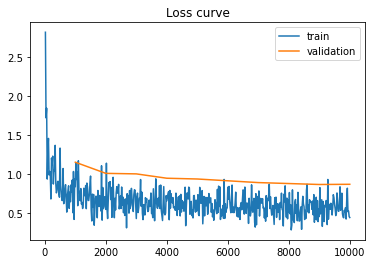

In [55]:
# 1. Loss curve
fig, ax = plt.subplots()

mdf1 = mdf[~mdf["total_loss"].isna()]
ax.plot(mdf1["iteration"], mdf1["total_loss"], c="C0", label="train")
if "validation_loss" in mdf.columns:
    mdf2 = mdf[~mdf["validation_loss"].isna()]
    ax.plot(mdf2["iteration"], mdf2["validation_loss"], c="C1", label="validation")

# ax.set_ylim([0, 0.5])
ax.legend()
ax.set_title("Loss curve")
plt.savefig("./output/loss.png")
plt.show()

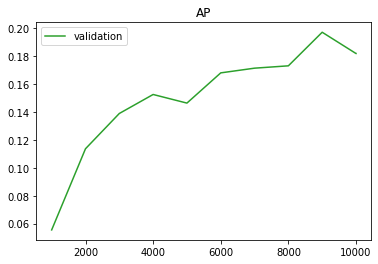

In [56]:
#plotting AP50 over time
fig, ax = plt.subplots()
mdf3 = mdf[~mdf["bbox/AP50"].isna()]
ax.plot(mdf3["iteration"], mdf3["bbox/AP50"] / 100., c="C2", label="validation")

ax.legend()
ax.set_title("AP")
plt.savefig("./output/AP.png")
plt.show()